# Analysis of Google Cloud Costs

## Introduction
This is a compilation of some observations regarding the Google Billing tables that can be generated by the Cloud Billing API. The dataset used here is a sample billing dataset available under Google's Public Datasets. I've filtered out 3 products (BigQuery, Cloud Storage, Compute Engine) that I'm interested in analyzing. 

The main focus for these three products are the ways in which cost is recorded in the billing data and how they can vary over a sample period of 7 months. This write-up will also serve as a repository for links to the appropriate Google Documentation for each particular resource and its measurement.

In [88]:
import os
import pandas as pd
from google.cloud import bigquery
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

df_daily = pd.read_gbq("select * from `intense-arbor-186802`.sample_data.top_3_prods",
                 project_id="intense-arbor-186802")

## Data Review

In [89]:
df_daily.head()

,start_time,product,unit,resource_type,cost,usage_amount
0,2017-05-20,BigQuery,bytes,Analysis,0.226763,4.986818e+10
1,2017-07-18,BigQuery,bytes,Analysis,0.093056,2.046715e+10
2,2017-09-17,BigQuery,bytes,Analysis,0.522707,1.149554e+11
3,2017-09-13,BigQuery,bytes,Analysis,0.186790,4.107692e+10
4,2017-10-21,BigQuery,bytes,Analysis,0.499131,1.097670e+11


The data has been prepared by the sql script available at `src/gcp_billing_sample.sql`
The data dictionary follows:
- `start_time` - the date on which the resource was used.
- `product` - the name of the Google product used
- `resource_type` - the exact resource of the product being used
- `cost` - the costs incurred by the resource and product
- `usage_amount` - the total usage by the resource and product (unused in this analysis)

We will bin `resource_type` into more understandable labels.

In [90]:
df_daily["resource_type"] = np.where(df_daily["resource_type"].str.contains("VCPU"),"VCPU",
         np.where(df_daily["resource_type"].str.contains("Fee"), "Licensing Fees",
                  np.where(df_daily["resource_type"].str.contains("GPU"), "GPU",
                           np.where(df_daily["resource_type"].str.contains("CPU"), "CPU",
#                                     np.where(df_daily["resource_type"].str.contains("Egress"), "Egress",
                                             np.where(df_daily["resource_type"].str.contains("PD"), "PD", 
                                                      np.where(df_daily["resource_type"].str.contains("Load Balancing"),"Load Balancing",
                                                              np.where(df_daily["resource_type"].str.contains("Custom instance"),"Custom Instance",
                                                                       np.where(df_daily["resource_type"].str.contains(" Regional Storage"),"Regional Storage",
                                                                               np.where(df_daily["resource_type"].str.contains("Multi-Regional Storage"),"Multi-Regional Storage",
                                                                                       np.where(df_daily["resource_type"].str.contains("Static Ip"), "Static Ip Charge",
                                                                                               df_daily["resource_type"]
                                                                                               )
                                                                                       )
                                                                               )
                                                                      )
                                                              )
                                                    )
#                                                )
                                      )
                            )
                    )
                                    )
                                             
                      
df_daily["resource_type"] = np.where((df_daily["resource_type"] == "Regional Storage US")|
                                     (df_daily["resource_type"] == "Regional Storage Asia"),
                                     "Regional Storage",
                                     df_daily["resource_type"])

In [91]:
# removing custom instance and GPU since they have very low counts
df_daily = df_daily[(df_daily["resource_type"] != "Custom Instance")]
df_daily = df_daily[(df_daily["resource_type"] != "GPU")]
df_daily["resource_type"].unique()

array(['Analysis', 'Vpn Tunnel', 'Storage Image', 'Active Storage',
       'Static Ip Charge', 'Streaming Insert', 'Long Term Storage',
       'Regional Storage', 'PD', 'Multi-Regional Storage',
       'Network Inter Zone Egress', 'CPU', 'VCPU',
       'Network Google Egress from Sydney to Sydney',
       'Network Internet Egress from Americas to EMEA',
       'Network Internet Egress from Americas to China',
       'Network Inter Region Egress from Americas to EMEA',
       'Network Internet Egress from Americas to Americas',
       'Network Inter Region Egress from Americas to Americas',
       'Network Vpn Internet Egress from Americas to Americas',
       'Licensing Fees', 'Load Balancing'], dtype=object)

In [92]:
df_daily["resource_type"] = np.where(df_daily["resource_type"].str.contains("Americas to Americas"), "Egress Americas to Americas",
         np.where((df_daily["resource_type"].str.contains("Sydney to Sydney")) | 
                  (df_daily["resource_type"].str.contains('Network Inter Zone Egress')),"Inter-zone Egress",
                  np.where(df_daily["resource_type"].str.contains("Americas to "),"Egress from Americas to Other",df_daily["resource_type"]
                          )
                 )
        )
df_daily["resource_type"].unique()

array(['Analysis', 'Vpn Tunnel', 'Storage Image', 'Active Storage',
       'Static Ip Charge', 'Streaming Insert', 'Long Term Storage',
       'Regional Storage', 'PD', 'Multi-Regional Storage',
       'Inter-zone Egress', 'CPU', 'VCPU',
       'Egress from Americas to Other', 'Egress Americas to Americas',
       'Licensing Fees', 'Load Balancing'], dtype=object)

In [93]:
# regrouping after binning resource_type
df_daily = df_daily.groupby(['start_time','product','resource_type','unit']).sum().reset_index()

In [94]:
def plot_prod(product, legend=True):
    df_daily_prod = df_daily[df_daily["product"] == product][["start_time","unit","cost","resource_type"]]

    units_available = list(df_daily_prod["unit"].unique())
    print(f"Units available:{units_available}")
    unit = input("Enter unit: ") 

    df_daily_prod_unit = df_daily_prod[df_daily_prod["unit"] ==unit]
    df_daily_prod_unit_pivot = pd.pivot_table(df_daily_prod_unit, 
                                         values="cost", 
                                         index="start_time", 
                                         columns=["resource_type"])

    for col in df_daily_prod_unit_pivot.columns:
        df_daily_prod_unit_pivot[col] = np.log(df_daily_prod_unit_pivot[col])

    df_daily_prod_unit_pivot.plot(title=product,figsize=(15,10),legend = legend)

## BigQuery Cost in Bytes

BigQuery costs in bytes are often consumed for either Analysis Queries(blue) or Streaming Inserts(orange). Examples of Analysis Queries include SQL queries, scripts, UDFs and other functions that can be exercised on BQ tables. Streaming Inserts figures track the cost involved in streaming data directly into BigQuery instead of using traditional batch updates. As expected, Streaming Inserts are more expensive ($0.01 per 200 MB) compared to batch uploads which are free when slot pricing is used.

- BigQuery pricing details [here](https://cloud.google.com/bigquery/pricing#overview_of_pricing).
- Streaming inserts vs Analysis Queries comparison [here](https://cloud.google.com/bigquery/pricing#data_ingestion_pricing).
- Analysis Pricing models [here](https://cloud.google.com/bigquery/pricing#analysis_pricing_models).

In the graph below, while Analysis Queries are fairly stable over the 7 month window, Streaming Insert costs have spiked early in the year and have risen in a step-wise fashion. The steps are clear during the beginning of 2017-06 with another escalation during the mid of 2017-07. 

Units available:['byte-seconds', 'bytes']
Enter unit: bytes


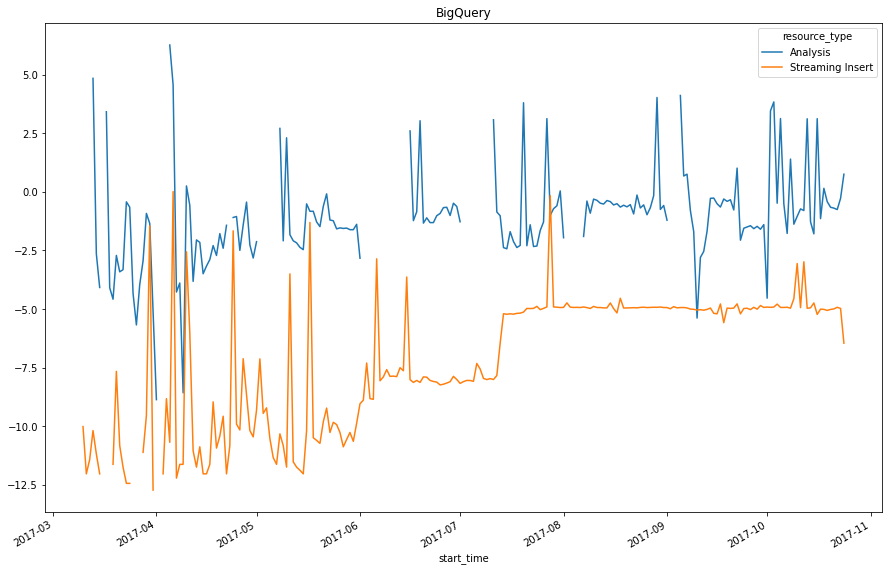

In [95]:
plot_prod("BigQuery")

## BigQuery Cost in Byte-Seconds

BigQuery costs in byte-seconds are measured for storage. Two types of storage are recorded in the billing data: Active Storage(blue) and Long Term Store(Orange). Active storage involves tables that have been updated for 90 days prior to storage classification. Long-term storage involves tables that has not been modified for 90 consecutive days. The price of storage is halved for tables that transition from Active to Long Term Storage. Details [here.](https://cloud.google.com/bigquery/pricing#storage)

From the graph below, we can see that the Long Term Storage lines have breaks showing periods of time when teams retire datasets that are no longer in use. The transition of tables from Active to Long Term Storage is also visibile in the first couple of months in the graph. While the Active Storage tables grow and remain undeleted, we see the peak for the costs rise at the end of the 90 day period (at about April-mid). Once the 90 day timeline hits, the Active costs go down due to the halving while Long Term costs rise from April-mid till end of May. Similar patterns later in the year become difficult to generalize since byte-seconds later in the year don't register the generation of new tables or deletion of old ones.

Units available:['byte-seconds', 'bytes']
Enter unit: byte-seconds


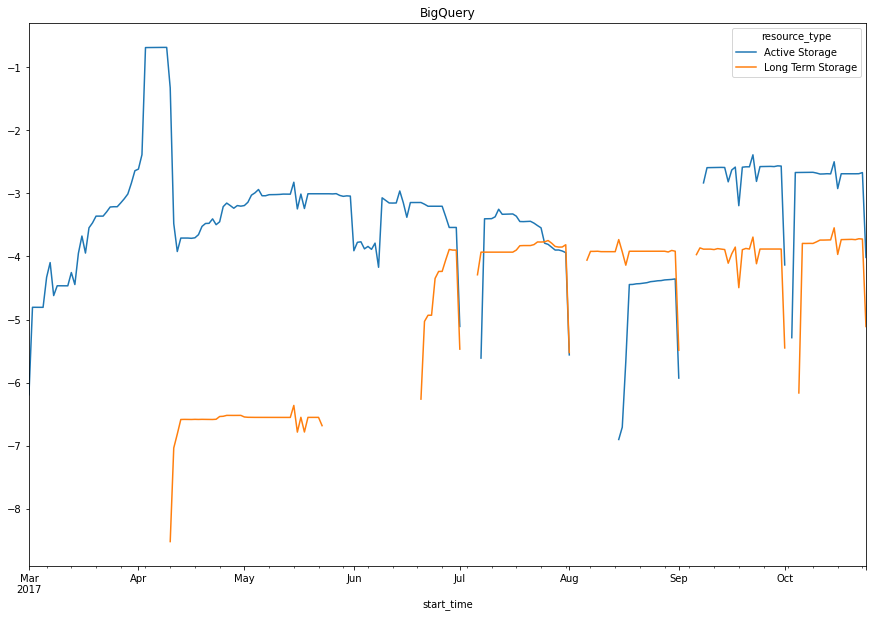

In [96]:
plot_prod("BigQuery")

## Cloud Storage Cost in Byte-Seconds

The Regional(orange) and Multi-Regional Storage(blue) measurements capture what fraction of GCS costs are incurred due to location. It costs more to store data in multiple regions; while availability is higher and latency is lower for apps deployed in these regions, the storage is more expensive. Details [here.](https://cloud.google.com/storage/docs/locations)

In the graph below, we see higher use of regional storage (likely for testing in 1 region before multi-region rollout of apps), these costs plummet at the end where Multi-regional storage is likely leveraged for later deployments.

Units available:['byte-seconds', 'requests']
Enter unit: byte-seconds


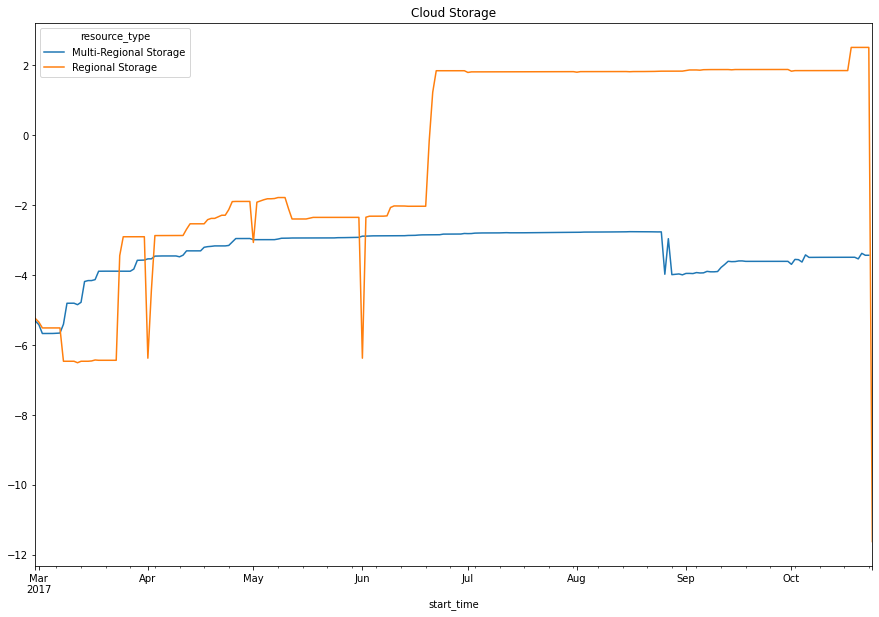

In [97]:
plot_prod("Cloud Storage")

## Google Compute Costs in Seconds


The Google Compute costs recorded as seconds mainly fall into the following categories:

1. CPU and vCPU - The most straightforward source of costs for a given VM. vCPU's tend to be more expensive than CPU's since they're more powerful. The machine type also heavily influences costs with general-type E2 machines costing less than memory-optimized M1 or M2 machines. The data does not record the type of machines that were spun to incur these costs but the usage is heavily vCPU driven according to the graph. More details [here](https://cloud.google.com/compute/vm-instance-pricing)

2. Licensing Fees - These are fees required to license images of SQL and other propriety products on spun up machines. More details [here](https://cloud.google.com/compute/disks-image-pricing)

3. VPN Tunnel - Google Cloud VPN's costs apply when the API is used for certain egress traffic. More details [here](https://cloud.google.com/vpc/network-pricing#vpn-pricing)

4. Load Balancing - Automatic load balancing of compute w.r.t traffic and load incurs these costs. We see a break in load balancing costs by the end of August 2017. This coincides with a significant dip in CPU/vCPU/Licensing costs. Some investigation into whether there was an outage of VMs during that time would be helpful. More details [here](https://cloud.google.com/vpc/network-pricing#lb)

5. Static IP Charge - Static IP addresses are charged as per details [here.](https://cloud.google.com/vpc/network-pricing#ipaddress)
    

Units available:['seconds', 'bytes', 'byte-seconds']
Enter unit: seconds


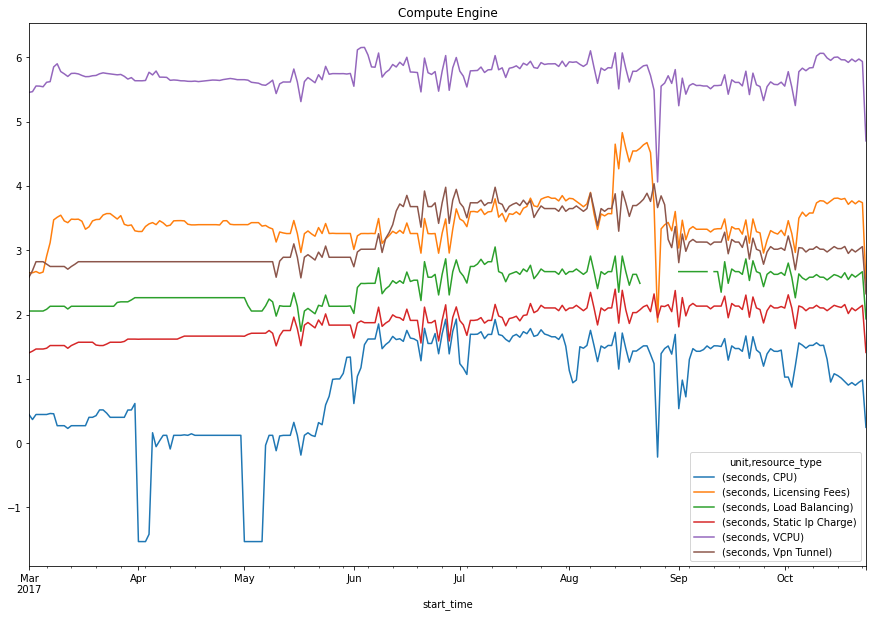

In [66]:
plot_prod("Compute Engine")

## Compute Engine Costs in Byte-Seconds

In byte-seconds, the costs accrued are recorded under persistent disk (PD) fees and Storage Image fees. Persistent disks vary by capacity and storage type. Stored Image costs are self-explanatory. Details available [here](https://cloud.google.com/compute/disks-image-pricing#persistentdisk).

Units available:['seconds', 'bytes', 'byte-seconds']
Enter unit: byte-seconds


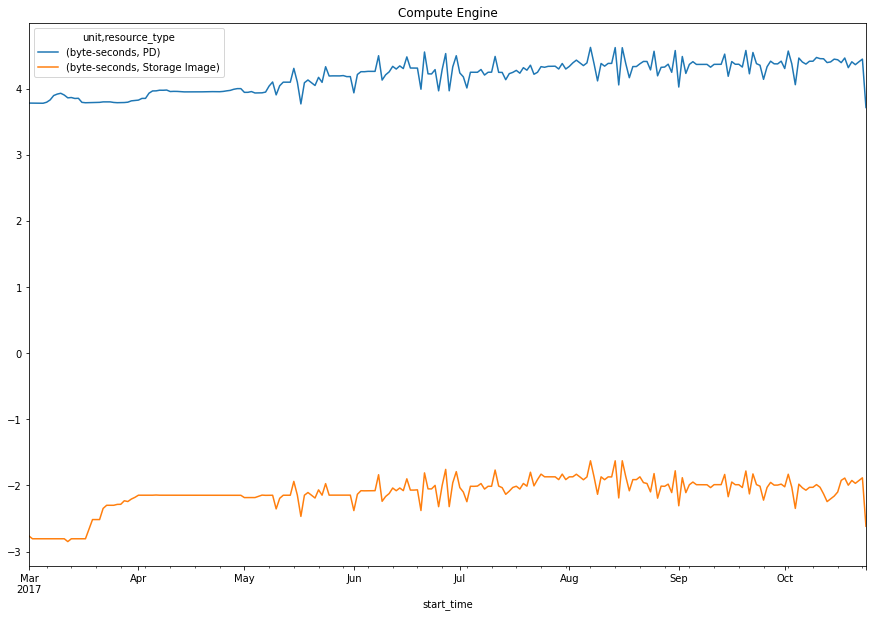

In [67]:
plot_prod("Compute Engine")

## Compute Engine Costs in Bytes (Egress Traffic)

Traffic and movement of data within the same zones are often free or charged less compared to traffic between different zones.
Comparison table [here](https://cloud.google.com/vpc/network-pricing#egress-within-gcp).

Units available:['seconds', 'bytes', 'byte-seconds']
Enter unit: bytes


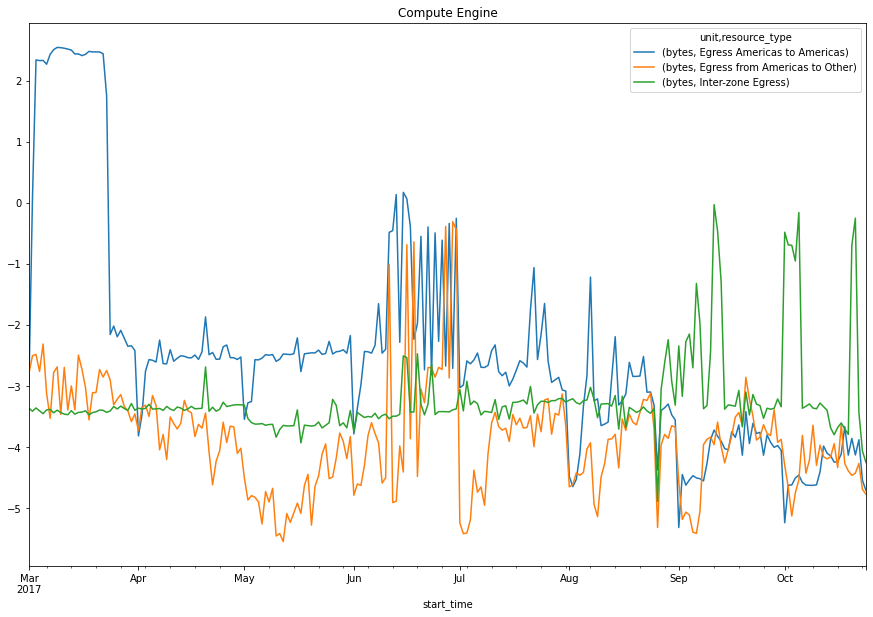

In [68]:
plot_prod("Compute Engine")